In [1]:
from typing import Any, OrderedDict
import torch
from torchvision.models.resnet import resnet50
from omegaconf import DictConfig
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [2]:
def get_backbone_from_ckpt(ckpt_path: str) -> torch.nn.Module:
    state_dict = torch.load(ckpt_path)["state_dict"]
    state_dict = OrderedDict([
        (".".join(name.split(".")[1:]), param) for name, param in state_dict.items() if name.startswith("backbone")
    ])

    return state_dict

In [3]:
# Baseline Model
model_bl  = resnet50()
weights_bl = get_backbone_from_ckpt("./r50_bt.ckpt")
model_bl.load_state_dict(weights_bl, strict=False)
model_bl.fc = torch.nn.Identity()
model_bl = model_bl.cuda()

In [4]:
# MixStyle Model
model_ms  = resnet50()
weights_ms = get_backbone_from_ckpt("./r50_bt_ms.ckpt")
model_ms.load_state_dict(weights_ms, strict=False)
model_ms.fc = torch.nn.Identity()
model_ms = model_ms.cuda()

In [5]:
from pacs_dm import PacsDM

In [6]:
cfg = DictConfig({
    'data_path': '/data',
    'param': {
        'batch_size': 16
    }
})

In [7]:
dm = PacsDM(cfg, leave_out=[])
dm.setup('fit')
train_loader = dm.train_dataloader()

In [8]:
x, t, d = next(iter(train_loader))

In [9]:
def embed(model, train_loader):
    with torch.no_grad():
        Z, T, D = [], [], []
        for x, t, d in tqdm(train_loader):
            z = model(x.cuda()).detach().cpu()
            Z.append(z)
            T.append(t)
            D.append(d)
        Z = torch.cat(Z, dim=0).contiguous()
        T = torch.cat(T, dim=0).contiguous()
        D = torch.cat(D, dim=0).contiguous()

    return dict(Z=Z, T=T, D=D)

In [10]:
embeddings = {
    'baseline': embed(model_bl, train_loader),
    'mixstyle': embed(model_ms, train_loader)
}

100%|██████████| 625/625 [00:05<00:00, 110.64it/s]


In [11]:
def plot_tsne(name, ax, Z, D):
    print('Plotting ...')

    pca = PCA(n_components=5)
    Z = pca.fit_transform(Z)

    Z_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=100).fit_transform(Z)
    
    # for d in torch.unique(D): # labels don't work if you scatter all domains at once
    #     ix = torch.where(D == d)
    #     ax.scatter(Z_tsne[ix,0], Z_tsne[ix,1], c=0, label=0)

    ax.scatter(Z_tsne[:,0], Z_tsne[:,1], c=D)

    # for z, d in zip(Z_tsne, D): # labels don't work if you scatter all domains at once, needs to use loop
    #     ax.scatter(z[0], z[1], c=int(d.item()))

    Z_train, Z_test, D_train, D_test = train_test_split(Z, D, test_size=0.4, random_state=42)

    logreg = LogisticRegression()
    logreg.fit(Z_train, D_train)

    D_pred = logreg.predict(Z_test)
    accuracy = accuracy_score(D_test, D_pred)
    ax.set_title(f"{name} Dom.-Accuracy: {accuracy:.2f}")

    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    

Plotting ...
Plotting ...


/tmp/ipykernel_31804/4240924900.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


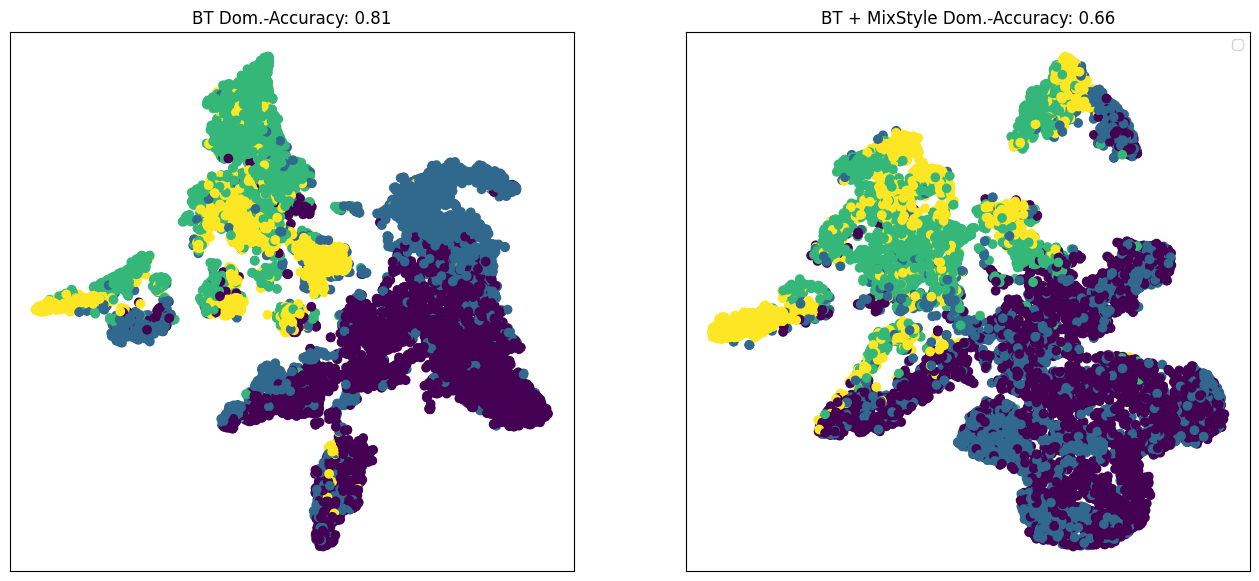

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(7)

plot_tsne('BT', ax1, Z=embeddings['baseline']['Z'], D=embeddings['baseline']['D'])
plot_tsne('BT + MixStyle', ax2, Z=embeddings['mixstyle']['Z'], D=embeddings['mixstyle']['D'])
plt.legend()